In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [5]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 64


In [6]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [7]:
train_dataset.dataset.label

tensor([ 7,  7,  7,  ..., 28,  3,  2], device='cuda:0')

In [8]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = np.concatenate([indices[:start], indices[end:]])
        trainval_indices = indices[start:end]
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        learning_rate = 0.1
        hidden_dim = 128

        # Initialize model and transfer to GPU
        model = MoannaModel(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.3177, Train Acc=0.1189, Val Acc=0.1543, Test Acc=0.1635
Fold 1/5, Epoch 2: Train Loss=3.0314, Train Acc=0.1806, Val Acc=0.1807, Test Acc=0.2065
Fold 1/5, Epoch 3: Train Loss=2.8059, Train Acc=0.2366, Val Acc=0.2668, Test Acc=0.3064
Fold 1/5, Epoch 4: Train Loss=2.5717, Train Acc=0.3146, Val Acc=0.3022, Test Acc=0.3591
Fold 1/5, Epoch 5: Train Loss=2.3634, Train Acc=0.3764, Val Acc=0.3465, Test Acc=0.4415
Fold 1/5, Epoch 6: Train Loss=2.1846, Train Acc=0.4433, Val Acc=0.3817, Test Acc=0.4822
Fold 1/5, Epoch 7: Train Loss=2.0200, Train Acc=0.4886, Val Acc=0.4124, Test Acc=0.5417
Fold 1/5, Epoch 8: Train Loss=1.8692, Train Acc=0.5373, Val Acc=0.4250, Test Acc=0.5814
Fold 1/5, Epoch 9: Train Loss=1.7366, Train Acc=0.5754, Val Acc=0.4395, Test Acc=0.6133
Fold 1/5, Epoch 10: Train Loss=1.6184, Train Acc=0.6077, Val Acc=0.4494, Test Acc=0.6377
Fold 1/5, Epoch 11: Train Loss=1.5075, Train Acc=0.6381, Val Acc=0.4414, Test Acc=0.6589
Fold 1/

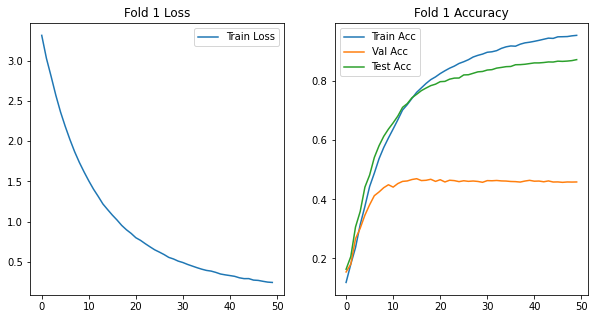

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.3181, Train Acc=0.1170, Val Acc=0.1597, Test Acc=0.1596
Fold 2/5, Epoch 2: Train Loss=3.0457, Train Acc=0.1747, Val Acc=0.1981, Test Acc=0.2098
Fold 2/5, Epoch 3: Train Loss=2.8058, Train Acc=0.2515, Val Acc=0.2757, Test Acc=0.3035
Fold 2/5, Epoch 4: Train Loss=2.5724, Train Acc=0.3115, Val Acc=0.3079, Test Acc=0.3562
Fold 2/5, Epoch 5: Train Loss=2.3536, Train Acc=0.3811, Val Acc=0.3717, Test Acc=0.4635
Fold 2/5, Epoch 6: Train Loss=2.1636, Train Acc=0.4554, Val Acc=0.4006, Test Acc=0.5199
Fold 2/5, Epoch 7: Train Loss=2.0081, Train Acc=0.5021, Val Acc=0.4229, Test Acc=0.5544
Fold 2/5, Epoch 8: Train Loss=1.8608, Train Acc=0.5392, Val Acc=0.4263, Test Acc=0.5863
Fold 2/5, Epoch 9: Train Loss=1.7293, Train Acc=0.5777, Val Acc=0.4245, Test Acc=0.6077
Fold 2/5, Epoch 10: Train Loss=1.6070, Train Acc=0.6124, Val Acc=0.4396, Test Acc=0.6367
Fold 2/5, Epoch 11: Train Loss=1.4881, Train Acc=0.6514, Val Acc=0.4468, Test Acc=0.6637
Fold 2/

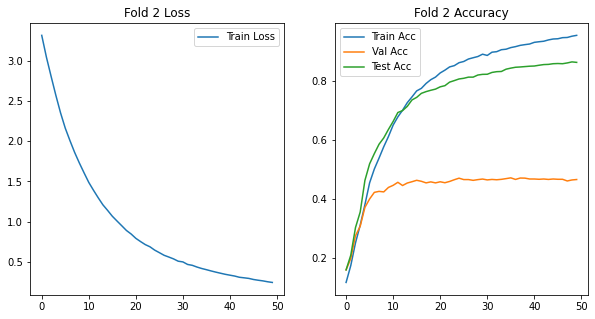

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.3131, Train Acc=0.1215, Val Acc=0.1641, Test Acc=0.1711
Fold 3/5, Epoch 2: Train Loss=3.0201, Train Acc=0.1831, Val Acc=0.1846, Test Acc=0.2049
Fold 3/5, Epoch 3: Train Loss=2.7842, Train Acc=0.2587, Val Acc=0.2596, Test Acc=0.3025
Fold 3/5, Epoch 4: Train Loss=2.5413, Train Acc=0.3271, Val Acc=0.3018, Test Acc=0.3757
Fold 3/5, Epoch 5: Train Loss=2.3376, Train Acc=0.3919, Val Acc=0.3307, Test Acc=0.4463
Fold 3/5, Epoch 6: Train Loss=2.1483, Train Acc=0.4539, Val Acc=0.3804, Test Acc=0.5247
Fold 3/5, Epoch 7: Train Loss=1.9924, Train Acc=0.5006, Val Acc=0.3936, Test Acc=0.5579
Fold 3/5, Epoch 8: Train Loss=1.8412, Train Acc=0.5429, Val Acc=0.4098, Test Acc=0.5977
Fold 3/5, Epoch 9: Train Loss=1.7135, Train Acc=0.5860, Val Acc=0.4183, Test Acc=0.6230
Fold 3/5, Epoch 10: Train Loss=1.5896, Train Acc=0.6112, Val Acc=0.4206, Test Acc=0.6507
Fold 3/5, Epoch 11: Train Loss=1.4733, Train Acc=0.6490, Val Acc=0.4393, Test Acc=0.6862
Fold 3/

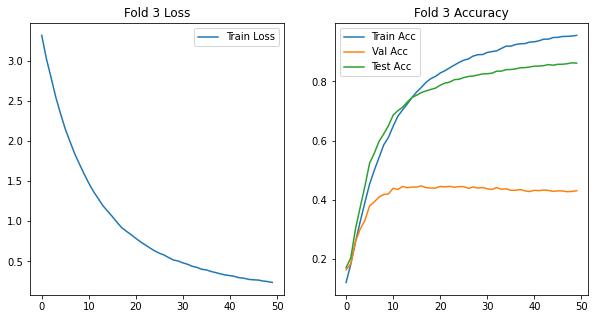

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.3351, Train Acc=0.1185, Val Acc=0.1712, Test Acc=0.1590
Fold 4/5, Epoch 2: Train Loss=3.0432, Train Acc=0.1779, Val Acc=0.2318, Test Acc=0.2348
Fold 4/5, Epoch 3: Train Loss=2.8038, Train Acc=0.2623, Val Acc=0.2757, Test Acc=0.2914
Fold 4/5, Epoch 4: Train Loss=2.5711, Train Acc=0.3156, Val Acc=0.3215, Test Acc=0.3650
Fold 4/5, Epoch 5: Train Loss=2.3530, Train Acc=0.3718, Val Acc=0.3568, Test Acc=0.4193
Fold 4/5, Epoch 6: Train Loss=2.1690, Train Acc=0.4475, Val Acc=0.3949, Test Acc=0.5225
Fold 4/5, Epoch 7: Train Loss=2.0058, Train Acc=0.4971, Val Acc=0.4100, Test Acc=0.5508
Fold 4/5, Epoch 8: Train Loss=1.8632, Train Acc=0.5388, Val Acc=0.4147, Test Acc=0.5700
Fold 4/5, Epoch 9: Train Loss=1.7308, Train Acc=0.5729, Val Acc=0.4370, Test Acc=0.6094
Fold 4/5, Epoch 10: Train Loss=1.6097, Train Acc=0.6071, Val Acc=0.4434, Test Acc=0.6426
Fold 4/5, Epoch 11: Train Loss=1.5040, Train Acc=0.6457, Val Acc=0.4473, Test Acc=0.6699
Fold 4/

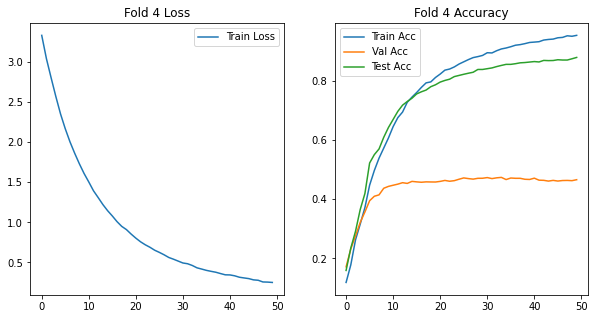

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.3155, Train Acc=0.1301, Val Acc=0.1649, Test Acc=0.1792
Fold 5/5, Epoch 2: Train Loss=3.0270, Train Acc=0.1851, Val Acc=0.1908, Test Acc=0.2257
Fold 5/5, Epoch 3: Train Loss=2.7987, Train Acc=0.2513, Val Acc=0.2858, Test Acc=0.3210
Fold 5/5, Epoch 4: Train Loss=2.5695, Train Acc=0.3232, Val Acc=0.3127, Test Acc=0.3559
Fold 5/5, Epoch 5: Train Loss=2.3498, Train Acc=0.3848, Val Acc=0.3475, Test Acc=0.4176
Fold 5/5, Epoch 6: Train Loss=2.1653, Train Acc=0.4502, Val Acc=0.4069, Test Acc=0.5156
Fold 5/5, Epoch 7: Train Loss=2.0036, Train Acc=0.4917, Val Acc=0.4419, Test Acc=0.5661
Fold 5/5, Epoch 8: Train Loss=1.8691, Train Acc=0.5366, Val Acc=0.4463, Test Acc=0.5967
Fold 5/5, Epoch 9: Train Loss=1.7238, Train Acc=0.5799, Val Acc=0.4474, Test Acc=0.6175
Fold 5/5, Epoch 10: Train Loss=1.6042, Train Acc=0.6147, Val Acc=0.4572, Test Acc=0.6436
Fold 5/5, Epoch 11: Train Loss=1.4906, Train Acc=0.6431, Val Acc=0.4549, Test Acc=0.6579
Fold 5/

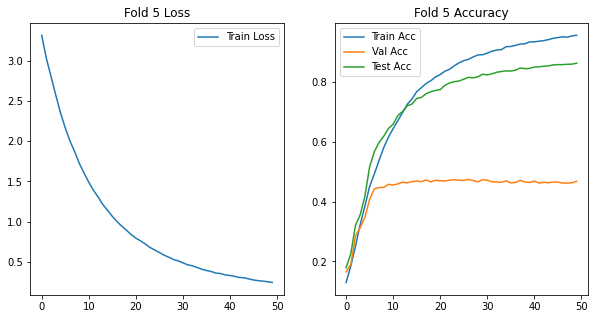

In [9]:
num_epochs = 50
k = 5

Model = k_fold_cross_validation(train_dataset.dataset, test_loader, k, num_epochs, batch_size, device=device, shuffle=True)

In [10]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [11]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [12]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.8727
Test Accuracy: 0.8643
Test Accuracy: 0.8620
Test Accuracy: 0.8796
Test Accuracy: 0.8613


In [13]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([29, 24, 26, 25,  1, 18, 18,  2, 22, 17,  1,  1, 27,  2,  2, 25, 13,  7,
        21, 13, 27, 10, 24, 13,  1, 27, 20,  6, 32, 10, 29, 13,  1, 29,  1, 21,
        10,  1, 15, 10,  1,  1, 15, 18, 25, 25,  8,  1,  0, 16,  6, 14, 15,  0,
        19, 18, 29, 21,  1, 28,  8, 24,  2, 18], device='cuda:0')
tensor([29, 24, 26, 25,  1, 18, 23,  2, 22, 17,  1,  1, 27,  2,  2, 25, 13,  7,
        21, 13, 12, 10, 24, 13,  1, 19, 11,  6, 32, 10, 29, 13,  1, 29,  1, 21,
        10,  1, 15, 10,  1,  1, 15, 18,  0, 18,  8,  1,  0, 25,  6, 14, 15,  0,
        14, 18, 29, 21,  1, 28,  8, 24,  2, 18], device='cuda:0')
tensor([30, 21, 22, 11, 16, 27, 18, 26,  0, 18, 10, 11,  1, 29,  7, 21, 16, 11,
        24,  1, 18, 17,  4, 20,  9, 21,  2, 10, 15, 17, 23,  7, 25,  1, 17, 15,
        25, 21,  4, 16, 29, 13,  1, 29, 21, 21, 28, 27, 15,  1, 16, 29,  1, 23,
        21, 22, 23,  8, 10, 27,  0,  8, 25,  5], device='cuda:0')
tensor([30, 21, 22, 11, 16, 27, 18, 26,  0, 14, 10, 11,  1, 29,  7, 27, 16, 11,
  